In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [3]:
rand_sub_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 6))

In [4]:
rand_sub_bval_indice_100206 = [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
       207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
       220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
       233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
       246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
       259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271]

In [5]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [6]:
normalized_scan_val_set_full = np.load(config.norm_data_path + '/normalized_scan_100307_full.npy')

In [7]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')
bvals_all_val_set = np.loadtxt(config.data_folder2 + '/100307/bvals')

In [8]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3
bvals_val_set_sub = bvals_all_val_set[rand_sub_bval_indice_100206]*1e-3

In [9]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]
normalized_scan_val_set_sub = normalized_scan_val_set_full[:, rand_sub_bval_indice_100206]

In [10]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]
big_b_indice_val_set_sub = np.where(bvals_val_set_sub != 0.005)[0]

In [11]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]
bvals_val_set_sub_no_b5 = bvals_val_set_sub[big_b_indice_val_set_sub]

In [12]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]
normalized_scan_val_set_sub_no_b5 = normalized_scan_val_set_sub[:, big_b_indice_val_set_sub]

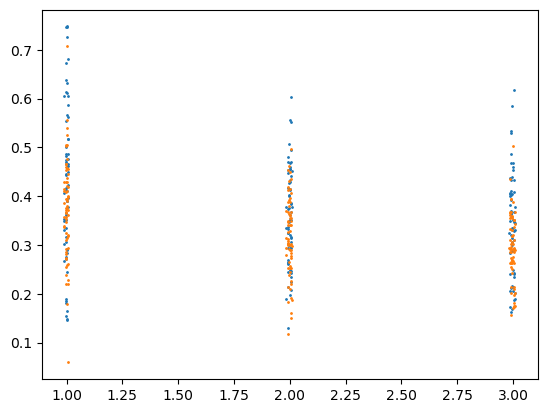

In [13]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)
plt.plot(bvals_val_set_sub_no_b5, normalized_scan_val_set_sub_no_b5[42,:], "o", markersize = 1)

In [14]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

n_val_set_all = np.loadtxt(config.data_folder2 + '/100307/bvecs')

In [15]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

n_val_set_sub = n_val_set_all[:, rand_sub_bval_indice_100206]
n_val_set_sub_no_b5 = n_val_set_sub[:,big_b_indice_val_set_sub].T
print(n_val_set_sub_no_b5.shape)

b_values_val_set_sub_no_b5 = torch.FloatTensor(bvals_val_set_sub_no_b5)
gradient_directions_val_set_sub_no_b5 = torch.FloatTensor(n_val_set_sub_no_b5)

(195, 3)
(195, 3)


In [16]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [17]:
batch_size = 128
val_num_batches = len(normalized_scan_val_set_sub_no_b5) // batch_size
valloader = utils.DataLoader(torch.from_numpy(normalized_scan_val_set_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [18]:
val_set = torch.from_numpy(normalized_scan_100610_sub_no_b5.astype(np.float32))
print(val_set.shape)
print(type(val_set))

NameError: name 'normalized_scan_100610_sub_no_b5' is not defined

In [19]:
bvals_num = len(b_values_100206_sub_no_b5)
net = network.BallStickNet(bvals_num)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [ ]:
train_loss_list=[]
avg_train_loss_list=[]

val_loss_list = []
avg_val_loss_list=[]

counter = 0

# Best loss
best_train_loss = 1e16
best_val_loss = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_train_loss = 0.
    
#     Training
    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch, gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        
    train_loss_list.append(running_train_loss)
    avg_train_loss_list.append(running_train_loss/num_batches)
    print("Loss: {}; Average Loss: {}".format(running_train_loss, running_train_loss/num_batches))
    
#     Validation
    # net.eval()
    # running_val_loss = 0.
    # with torch.no_grad():
    #     val_pred, _, _, _, _, _, _, _ = net(val_set, gradient_directions_100610_sub_no_b5, b_values_100610_sub_no_b5)
    #     val_loss = criterion(val_pred.type(torch.FloatTensor), val_set.type(torch.FloatTensor))
    #     running_val_loss += val_loss.item()
    # val_loss_list.append(running_val_loss)
    # print("Validation Loss: {}".format(running_val_loss))
    
    net.eval()
    running_val_loss = 0.
    with torch.no_grad():
        for i, val_batch in enumerate(tqdm(valloader), 0):
            val_pred, _, _, _, _, _, _, _ = net(val_batch,gradient_directions_val_set_sub_no_b5, b_values_val_set_sub_no_b5)
            val_loss = criterion(val_pred.type(torch.FloatTensor), val_batch.type(torch.FloatTensor))
            running_val_loss += val_loss.item()
    val_loss_list.append(running_val_loss)
    avg_val_loss_list.append(running_val_loss/val_num_batches)
    print("Val Loss: {}; Average Val Loss: {}".format(running_val_loss, running_val_loss/val_num_batches))
            

    # if running_train_loss < best_train_loss and running_val_loss < best_val_loss:
    if running_train_loss < best_train_loss:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best_train_loss = running_train_loss
        # best_val_loss = running_val_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best training loss: {}; best validation loss: {}".format(best_train_loss, best_val_loss))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.92it/s]


Loss: 515.008202124387; Average Loss: 0.07047183937115312


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 428.05it/s]


Val Loss: 229.4821629510261; Average Val Loss: 0.039689063118475636
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.96it/s]


Loss: 432.7785916281864; Average Loss: 0.05921984012427291


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 470.55it/s]


Val Loss: 227.95736134098843; Average Val Loss: 0.03942534786250232
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.66it/s]


Loss: 429.6480699358508; Average Loss: 0.058791470981917185


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:11<00:00, 488.07it/s]


Val Loss: 227.79895937116817; Average Val Loss: 0.03939795215689522
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.97it/s]


Loss: 428.751140373759; Average Loss: 0.05866873842005459


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:11<00:00, 493.94it/s]


Val Loss: 229.69333420088515; Average Val Loss: 0.03972558529935751
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.53it/s]


Loss: 428.2644357890822; Average Loss: 0.05860213954420938


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 478.68it/s]


Val Loss: 230.80037464760244; Average Val Loss: 0.03991704853815331
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.75it/s]


Loss: 427.48355174344033; Average Loss: 0.058495286226524404


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:11<00:00, 486.22it/s]


Val Loss: 232.8133322680369; Average Val Loss: 0.04026519063784796
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.76it/s]


Loss: 427.143248826731; Average Loss: 0.058448720419640256


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:11<00:00, 485.47it/s]


Val Loss: 236.62091657146811; Average Val Loss: 0.04092371438455
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.54it/s]


Loss: 425.09386625047773; Average Loss: 0.05816829040099586


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 472.44it/s]


Val Loss: 238.74442578665912; Average Val Loss: 0.04129097644182966
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.55it/s]


Loss: 426.3893201914616; Average Loss: 0.05834555558175446


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 435.12it/s]


Val Loss: 241.47066654497758; Average Val Loss: 0.04176248124264573
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.37it/s]


Loss: 425.87120086094365; Average Loss: 0.05827465802694905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 438.51it/s]


Val Loss: 241.15673621976748; Average Val Loss: 0.04170818682458794
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 2


  2%|██▋                                                                                                                                                           | 127/7308 [00:02<00:51, 138.27it/s]

X_batch: 
torch.Size([128, 195])
tensor([[0.4591, 0.3496, 0.5210,  ..., 0.7535, 0.4521, 0.5262],
        [0.2303, 0.2443, 0.1019,  ..., 0.0883, 0.0708, 0.2087],
        [0.6411, 0.2217, 0.2591,  ..., 0.6402, 0.2331, 0.1998],
        ...,
        [0.2831, 0.2215, 0.3756,  ..., 0.1981, 0.2129, 0.3608],
        [0.3005, 0.4657, 0.4046,  ..., 0.8379, 0.1808, 0.4203],
        [0.6584, 0.2942, 0.2221,  ..., 0.6693, 0.3117, 0.4311]])
X_pred: 
torch.Size([128, 195])
tensor([[0.6700, 0.5441, 0.4213,  ..., 0.6389, 0.4657, 0.5263],
        [0.2402, 0.1797, 0.1447,  ..., 0.2290, 0.1592, 0.1752],
        [0.5809, 0.3855, 0.2570,  ..., 0.5657, 0.2784, 0.3749],
        ...,
        [0.3810, 0.2811, 0.2201,  ..., 0.3641, 0.2427, 0.2731],
        [0.6275, 0.4486, 0.3159,  ..., 0.6076, 0.3435, 0.4369],
        [0.5632, 0.3642, 0.2377,  ..., 0.5494, 0.2584, 0.3523]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.88it/s]


Loss: 425.09470853954554; Average Loss: 0.05816840565675226


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 477.74it/s]


Val Loss: 244.97081075794995; Average Val Loss: 0.042367833060869935
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.74it/s]


Loss: 426.1516008018516; Average Loss: 0.058313026929645816


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 474.07it/s]


Val Loss: 250.2813853523694; Average Val Loss: 0.04328629978422162
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.11it/s]


Loss: 425.3731766785495; Average Loss: 0.05820651021873967


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 437.79it/s]


Val Loss: 249.85883213439956; Average Val Loss: 0.043213218978623236
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.14it/s]


Loss: 425.0116388462484; Average Loss: 0.05815703870364647


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 477.35it/s]


Val Loss: 248.7777141048573; Average Val Loss: 0.04302623903577608
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.40it/s]


Loss: 425.52304618246853; Average Loss: 0.058227017813693015


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 481.05it/s]


Val Loss: 251.8475313889794; Average Val Loss: 0.043557165580937286
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.50it/s]


Loss: 424.7033072914928; Average Loss: 0.05811484774103624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:11<00:00, 485.10it/s]


Val Loss: 255.46847088029608; Average Val Loss: 0.04418340900731513
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.25it/s]


Loss: 424.94765037624165; Average Loss: 0.058148282755369686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:11<00:00, 483.73it/s]


Val Loss: 256.39916084799916; Average Val Loss: 0.044344372336215694
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.42it/s]


Loss: 425.0570334601216; Average Loss: 0.05816325033663405


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:11<00:00, 488.70it/s]


Val Loss: 254.64156044833362; Average Val Loss: 0.04404039440476196
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.91it/s]


Loss: 424.33357282029465; Average Loss: 0.058064254627845466


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 477.06it/s]


Val Loss: 257.7503519030288; Average Val Loss: 0.044578061553619645
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.22it/s]


Loss: 423.92580797942355; Average Loss: 0.05800845757791784


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:11<00:00, 484.37it/s]


Val Loss: 257.11543607898057; Average Val Loss: 0.04446825252144251
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.67it/s]


Loss: 424.2218888150528; Average Loss: 0.058048972196914725


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 466.38it/s]


Val Loss: 256.56063246447593; Average Val Loss: 0.04437229893885782
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.32it/s]


Loss: 424.0222948351875; Average Loss: 0.05802166048647886


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:11<00:00, 489.09it/s]


Val Loss: 256.68466581217945; Average Val Loss: 0.04439375057284321
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.66it/s]


Loss: 423.53127430332825; Average Loss: 0.05795447103220146


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 481.75it/s]


Val Loss: 259.52831615787; Average Val Loss: 0.04488556142474403
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.84it/s]


Loss: 423.7156973197125; Average Loss: 0.05797970680346367


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 469.34it/s]


Val Loss: 256.7656669570133; Average Val Loss: 0.04440775976427072
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.69it/s]


Loss: 424.01996124722064; Average Loss: 0.0580213411668337


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 454.08it/s]


Val Loss: 260.8852621195838; Average Val Loss: 0.04512024595634448
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 192.22it/s]


Loss: 424.25940587278455; Average Loss: 0.058054105893922354


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 473.03it/s]


Val Loss: 261.79524074401706; Average Val Loss: 0.04527762724732222
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.66it/s]


Loss: 422.8680073954165; Average Loss: 0.05786371201360379


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 454.84it/s]


Val Loss: 259.77118079178035; Average Val Loss: 0.044927564993389894
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.28it/s]


Loss: 423.6742280605249; Average Loss: 0.05797403230165913


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 450.18it/s]


Val Loss: 264.0434208922088; Average Val Loss: 0.045666451209306264
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.51it/s]


Loss: 423.232942096889; Average Loss: 0.05791364834385455


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 452.09it/s]


Val Loss: 263.001791452989; Average Val Loss: 0.045486300839327046
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.38it/s]


Loss: 423.48389708669856; Average Loss: 0.05794798810710161


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 464.15it/s]


Val Loss: 261.7913274746388; Average Val Loss: 0.045276950445285166
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.29it/s]


Loss: 423.35083185182884; Average Loss: 0.05792977994688408


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 447.69it/s]


Val Loss: 263.97297312133014; Average Val Loss: 0.04565426722956246
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.98it/s]


Loss: 423.6633873889223; Average Loss: 0.057972548903793414


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 462.57it/s]


Val Loss: 263.4807250443846; Average Val Loss: 0.04556913266073757
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.88it/s]


Loss: 423.10166175244376; Average Loss: 0.057895684421516665


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 443.57it/s]


Val Loss: 264.5539766866714; Average Val Loss: 0.04575475210769135
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.57it/s]


Loss: 423.22356016747653; Average Loss: 0.057912364554936584


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 446.64it/s]


Val Loss: 264.88856089580804; Average Val Loss: 0.04581261862604774
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.57it/s]


Loss: 423.2863802248612; Average Loss: 0.05792096062190219


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 452.54it/s]


Val Loss: 264.81975056417286; Average Val Loss: 0.045800717842299006
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.54it/s]


Loss: 422.54673732817173; Average Loss: 0.057819750592251196


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 463.14it/s]


Val Loss: 266.1359495529905; Average Val Loss: 0.046028355163090715
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.69it/s]


Loss: 422.6073887194507; Average Loss: 0.05782804990687612


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:14<00:00, 389.70it/s]


Val Loss: 268.8804373797029; Average Val Loss: 0.046503015804168615
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.48it/s]


Loss: 422.5779456910677; Average Loss: 0.057824021030523774


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:11<00:00, 493.74it/s]


Val Loss: 268.7612762860954; Average Val Loss: 0.046482406829141364
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.33it/s]


Loss: 423.2993777189404; Average Loss: 0.05792273915146967


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:11<00:00, 486.45it/s]


Val Loss: 269.44129502400756; Average Val Loss: 0.04660001643445305
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.69it/s]


Loss: 422.7539410861209; Average Loss: 0.057848103596896676


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:15<00:00, 375.26it/s]


Val Loss: 267.8285173596814; Average Val Loss: 0.04632108567272249
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.12it/s]


Loss: 422.3844989123754; Average Loss: 0.05779755048062061


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 437.49it/s]


Val Loss: 270.76628343295306; Average Val Loss: 0.04682917389016829
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.82it/s]


Loss: 422.6565332887694; Average Loss: 0.05783477467005602


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 440.89it/s]


Val Loss: 268.5036974269897; Average Val Loss: 0.04643785842735899
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.34it/s]


Loss: 422.25261255865917; Average Loss: 0.057779503634189815


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 443.53it/s]


Val Loss: 268.0673953248188; Average Val Loss: 0.04636239974486662
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.07it/s]


Loss: 422.2123427200131; Average Loss: 0.05777399325670678


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 444.12it/s]


Val Loss: 271.9789064945653; Average Val Loss: 0.04703889769881794
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.25it/s]


Loss: 422.7837276272476; Average Loss: 0.0578521794782769


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 434.54it/s]


Val Loss: 269.9588624415919; Average Val Loss: 0.04668952999681631
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.00it/s]


Loss: 422.1882763444446; Average Loss: 0.05777070010186708


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 442.92it/s]


Val Loss: 271.64377872645855; Average Val Loss: 0.04698093717164624
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 192.18it/s]


Loss: 422.36007772991434; Average Loss: 0.057794208775303


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 452.97it/s]


Val Loss: 272.23654486145824; Average Val Loss: 0.04708345639250402
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.16it/s]


Loss: 422.1210231259465; Average Loss: 0.05776149741734353


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 431.29it/s]


Val Loss: 273.77714959159493; Average Val Loss: 0.047349904806571246
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.26it/s]


Loss: 422.4704726408236; Average Loss: 0.05780931481127854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 448.58it/s]


Val Loss: 271.67407212685794; Average Val Loss: 0.04698617643148702
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.01it/s]


Loss: 421.8407720043324; Average Loss: 0.05772314887853481


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 428.82it/s]


Val Loss: 272.3536952920258; Average Val Loss: 0.047103717622280494
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.50it/s]


Loss: 422.1907550082542; Average Loss: 0.05777103927316012


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 437.22it/s]


Val Loss: 272.80184601340443; Average Val Loss: 0.04718122552981744
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.66it/s]


Loss: 422.12701725400984; Average Loss: 0.05776231763191158


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:14<00:00, 391.72it/s]


Val Loss: 274.3137602098286; Average Val Loss: 0.04744271190069675
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.64it/s]


Loss: 422.30081232683733; Average Loss: 0.057786099114236086


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:11<00:00, 485.06it/s]


Val Loss: 275.2467329343781; Average Val Loss: 0.047604070033617794
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.88it/s]


Loss: 422.17977662663907; Average Loss: 0.057769537031559806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:11<00:00, 483.23it/s]


Val Loss: 276.13654692843556; Average Val Loss: 0.047757963840960836
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.23it/s]


Loss: 421.54767770227045; Average Loss: 0.05768304292587171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 471.50it/s]


Val Loss: 274.5163149442524; Average Val Loss: 0.04747774385061439
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.41it/s]


Loss: 420.9479745985009; Average Loss: 0.05760098174582661


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 467.73it/s]


Val Loss: 277.6084233429283; Average Val Loss: 0.04801252565598898
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.11it/s]


Loss: 421.53524167183787; Average Loss: 0.05768134122493676


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:16<00:00, 351.22it/s]


Val Loss: 277.12947414442897; Average Val Loss: 0.04792969113532151
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.03it/s]


Loss: 421.88933383859694; Average Loss: 0.05772979390238053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 473.09it/s]


Val Loss: 277.3821879643947; Average Val Loss: 0.04797339812597625
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.90it/s]


Loss: 421.27698230557144; Average Loss: 0.05764600195752209


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:14<00:00, 391.71it/s]


Val Loss: 276.79386465251446; Average Val Loss: 0.047871647293758986
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.48it/s]


Loss: 421.9053539647721; Average Loss: 0.05773198603787248


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 439.58it/s]


Val Loss: 277.4114514403045; Average Val Loss: 0.04797845925982437
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.34it/s]


Loss: 421.17248095106333; Average Loss: 0.057631702374256064


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 424.73it/s]


Val Loss: 276.79987098276615; Average Val Loss: 0.04787268609179629
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.00it/s]


Loss: 420.84729971084744; Average Loss: 0.0575872057622944


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 446.38it/s]


Val Loss: 280.54998724348843; Average Val Loss: 0.048521270709700526
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.52it/s]


Loss: 420.54963179305196; Average Loss: 0.05754647397277668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 442.40it/s]


Val Loss: 279.1366324853152; Average Val Loss: 0.04827683024650903
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.28it/s]


Loss: 420.5246916557662; Average Loss: 0.0575430612555783


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 420.74it/s]


Val Loss: 277.83844900969416; Average Val Loss: 0.04805230871838363
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.51it/s]


Loss: 421.1820610235445; Average Loss: 0.05763301327634709


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 426.70it/s]


Val Loss: 276.76949694473296; Average Val Loss: 0.04786743288563351
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.24it/s]


Loss: 420.50857802992687; Average Loss: 0.05754085632593416


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 423.88it/s]


Val Loss: 276.88979046233; Average Val Loss: 0.04788823771399688
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.27it/s]


Loss: 421.1935583348386; Average Loss: 0.05763458652638733


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 414.10it/s]


Val Loss: 278.75778089649975; Average Val Loss: 0.04821130766110338
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.39it/s]


Loss: 420.6198885869235; Average Loss: 0.05755608765557245


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 440.55it/s]


Val Loss: 278.48265159502625; Average Val Loss: 0.048163723900903885
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.52it/s]


Loss: 420.33991544134915; Average Loss: 0.05751777715398866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:14<00:00, 394.56it/s]


Val Loss: 282.6198437465355; Average Val Loss: 0.048879253501649164
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.27it/s]


Loss: 420.2574405297637; Average Loss: 0.05750649158863762


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:11<00:00, 494.78it/s]


Val Loss: 282.3602883061394; Average Val Loss: 0.048834363249072886
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.66it/s]


Loss: 420.1317826099694; Average Loss: 0.05748929701833188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:16<00:00, 349.25it/s]


Val Loss: 279.75633274856955; Average Val Loss: 0.048384007739289095
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.01it/s]


Loss: 420.30231819394976; Average Loss: 0.057512632484120106


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 434.86it/s]


Val Loss: 281.71614283975214; Average Val Loss: 0.04872295794530476
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.06it/s]


Loss: 419.89217913430184; Average Loss: 0.05745651055477584


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:14<00:00, 404.06it/s]


Val Loss: 279.9279047390446; Average Val Loss: 0.048413681207029505
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.72it/s]


Loss: 420.3402829300612; Average Loss: 0.057517827439800384


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:14<00:00, 406.43it/s]


Val Loss: 279.8190251486376; Average Val Loss: 0.04839485042349318
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.21it/s]


Loss: 420.43814576091245; Average Loss: 0.057531218631761416


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 421.12it/s]


Val Loss: 280.6732095191255; Average Val Loss: 0.04854258206833717
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.24it/s]


Loss: 419.36223177146167; Average Loss: 0.0573839944952739


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 427.76it/s]


Val Loss: 280.41074494831264; Average Val Loss: 0.04849718868009558
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.85it/s]


Loss: 419.8934605657123; Average Loss: 0.05745668590116479


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 440.22it/s]


Val Loss: 282.1125677479431; Average Val Loss: 0.04879151984571828
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.56it/s]


Loss: 419.726978992112; Average Loss: 0.057433905171334426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 413.40it/s]


Val Loss: 283.9244324695319; Average Val Loss: 0.04910488282074228
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.26it/s]


Loss: 420.09223122382537; Average Loss: 0.057483884951262366


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 427.63it/s]


Val Loss: 282.14895560313016; Average Val Loss: 0.04879781314478211
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.13it/s]


Loss: 419.96014818828553; Average Loss: 0.05746581119160995


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:14<00:00, 411.32it/s]


Val Loss: 285.25336904264987; Average Val Loss: 0.049334723113567944
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.14it/s]


Loss: 419.805913281627; Average Loss: 0.057444706250906814


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 439.59it/s]


Val Loss: 280.0635721087456; Average Val Loss: 0.0484371449513569
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.95it/s]


Loss: 419.46234622970223; Average Loss: 0.05739769379169434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:14<00:00, 407.86it/s]


Val Loss: 284.1420300360769; Average Val Loss: 0.049142516436540454
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.85it/s]


Loss: 419.5307556842454; Average Loss: 0.05740705469133078


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:11<00:00, 486.85it/s]


Val Loss: 285.6489824960008; Average Val Loss: 0.04940314467243183
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.39it/s]


Loss: 419.0909823332913; Average Loss: 0.05734687771391507


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 454.52it/s]


Val Loss: 285.28377503342927; Average Val Loss: 0.049339981845975316
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.24it/s]


Loss: 419.6017928812653; Average Loss: 0.057416775161640024


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 429.24it/s]


Val Loss: 285.18313861917704; Average Val Loss: 0.04932257672417451
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.14it/s]


Loss: 419.17290588701144; Average Loss: 0.05735808783347174


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 464.62it/s]


Val Loss: 283.5678063556552; Average Val Loss: 0.04904320414314341
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.03it/s]


Loss: 419.01405634963885; Average Loss: 0.057336351443574005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 464.33it/s]


Val Loss: 284.71304753329605; Average Val Loss: 0.04924127421883363
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.52it/s]


Loss: 419.175130601041; Average Loss: 0.05735839225520539


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 460.94it/s]


Val Loss: 285.69104439020157; Average Val Loss: 0.04941041929958519
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.15it/s]


Loss: 418.86878353124484; Average Loss: 0.0573164728422612


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 439.85it/s]


Val Loss: 286.238559037447; Average Val Loss: 0.04950511225137443
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.77it/s]


Loss: 418.9143334319815; Average Loss: 0.0573227057241354


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:16<00:00, 360.00it/s]


Val Loss: 285.450425603427; Average Val Loss: 0.04936880415140557
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 182.74it/s]


Loss: 419.08350891713053; Average Loss: 0.057345855078972434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 472.17it/s]


Val Loss: 286.6324607571587; Average Val Loss: 0.04957323776498767
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 192.31it/s]


Loss: 419.25715463329107; Average Loss: 0.05736961612387672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 462.29it/s]


Val Loss: 285.6080743940547; Average Val Loss: 0.049396069594267504
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.86it/s]


Loss: 419.04791909991764; Average Loss: 0.0573409850985109


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 437.50it/s]


Val Loss: 286.6539986645803; Average Val Loss: 0.04957696275762371
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.34it/s]


Loss: 419.0980095118284; Average Loss: 0.05734783928733284


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 450.72it/s]


Val Loss: 290.16895031463355; Average Val Loss: 0.05018487553003002
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.54it/s]


Loss: 418.70780697558075; Average Loss: 0.05729444539895741


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 448.16it/s]


Val Loss: 284.2468944871798; Average Val Loss: 0.04916065279958143
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.61it/s]


Loss: 418.8326063910499; Average Loss: 0.05731152249467021


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 453.00it/s]


Val Loss: 287.82206141669303; Average Val Loss: 0.04977897983685455
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.55it/s]


Loss: 418.803578001447; Average Loss: 0.0573075503559725


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 451.92it/s]


Val Loss: 289.6460888683796; Average Val Loss: 0.050094446362569975
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.97it/s]


Loss: 418.7781353688333; Average Loss: 0.0573040688791507


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 453.13it/s]


Val Loss: 291.5341365067288; Average Val Loss: 0.05042098521389291
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.94it/s]


Loss: 418.578963924665; Average Loss: 0.05727681498695471


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:14<00:00, 399.31it/s]


Val Loss: 288.8011009404436; Average Val Loss: 0.049948305247395984
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.32it/s]


Loss: 418.3841380449012; Average Loss: 0.057250155725903286


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 419.33it/s]


Val Loss: 290.69255956914276; Average Val Loss: 0.05027543403132874
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.78it/s]


Loss: 418.57489882037044; Average Loss: 0.057276258732946145


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 452.03it/s]


Val Loss: 289.1586794247851; Average Val Loss: 0.050010148637977356
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.66it/s]


Loss: 418.88799716951326; Average Loss: 0.05731910196627166


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 466.03it/s]


Val Loss: 292.9464574921876; Average Val Loss: 0.050665246885539195
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.33it/s]


Loss: 418.47879258543253; Average Loss: 0.05726310790714731


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 472.35it/s]


Val Loss: 292.4068250376731; Average Val Loss: 0.050571917163208774
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.83it/s]


Loss: 418.258335982915; Average Loss: 0.057232941431707034


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 473.92it/s]


Val Loss: 293.59578353818506; Average Val Loss: 0.05077754817332844
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.48it/s]


Loss: 418.1859143190086; Average Loss: 0.057223031516011026


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 453.04it/s]


Val Loss: 291.8523835474625; Average Val Loss: 0.050476026210214894
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.54it/s]


Loss: 418.4264297890477; Average Loss: 0.05725594277354237


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 451.09it/s]


Val Loss: 292.81386747024953; Average Val Loss: 0.0506423153701573
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.82it/s]


Loss: 418.4072692883201; Average Loss: 0.057253320920678724


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 462.51it/s]


Val Loss: 297.5668636187911; Average Val Loss: 0.051464348602350586
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.81it/s]


Loss: 418.3204972445965; Average Loss: 0.05724144735147735


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 458.42it/s]


Val Loss: 296.4609552146867; Average Val Loss: 0.05127308115093163
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.41it/s]


Loss: 418.33858144050464; Average Loss: 0.05724392192672477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 466.51it/s]


Val Loss: 298.7828814703971; Average Val Loss: 0.05167465954174976
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.08it/s]


Loss: 417.9976586489938; Average Loss: 0.05719727129843922


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 462.66it/s]


Val Loss: 294.9545263228938; Average Val Loss: 0.05101254346642923
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.44it/s]


Loss: 417.3813403355889; Average Loss: 0.05711293655385727


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 461.25it/s]


Val Loss: 293.8564470652491; Average Val Loss: 0.05082263007008805
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.19it/s]


Loss: 417.18192817037925; Average Loss: 0.05708564972227412


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 455.13it/s]


Val Loss: 295.89045247249305; Average Val Loss: 0.0511744123957961
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.68it/s]


Loss: 417.0772631880827; Average Loss: 0.05707132774877979


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 468.24it/s]


Val Loss: 293.99282891489565; Average Val Loss: 0.050846217384105094
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.53it/s]


Loss: 417.1150211088825; Average Loss: 0.05707649440460899


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 467.80it/s]


Val Loss: 295.51178995799273; Average Val Loss: 0.051108922510894626
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.60it/s]


Loss: 416.6628786032088; Average Loss: 0.057014624877286375


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 466.48it/s]


Val Loss: 294.61333425622433; Average Val Loss: 0.05095353411556976
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.95it/s]


Loss: 416.6573269693181; Average Loss: 0.05701386521200302


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 466.03it/s]


Val Loss: 296.5722697759047; Average Val Loss: 0.051292333063975216
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.62it/s]


Loss: 416.26552889030427; Average Loss: 0.0569602529953892


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 466.10it/s]


Val Loss: 298.8206048477441; Average Val Loss: 0.051681183820087184
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.92it/s]


Loss: 416.32746461592615; Average Loss: 0.05696872805362974


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 458.81it/s]


Val Loss: 296.7845596438274; Average Val Loss: 0.05132904871045095
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.74it/s]


Loss: 416.196736021433; Average Loss: 0.056950839630737965


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 458.74it/s]


Val Loss: 295.13780714944005; Average Val Loss: 0.05104424198364581
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.65it/s]


Loss: 416.2352289990522; Average Loss: 0.05695610686905476


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 466.95it/s]


Val Loss: 298.7808992182836; Average Val Loss: 0.05167431671018395
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.79it/s]


Loss: 415.9168731009122; Average Loss: 0.05691254421194748


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 463.56it/s]


Val Loss: 297.102318351157; Average Val Loss: 0.051384005249248875
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.96it/s]


Loss: 416.1570046180859; Average Loss: 0.05694540293077257


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 463.45it/s]


Val Loss: 302.4353406764567; Average Val Loss: 0.05230635431969158
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.33it/s]


Loss: 415.7951844474301; Average Loss: 0.05689589278153121


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 450.48it/s]


Val Loss: 300.64712417311966; Average Val Loss: 0.05199708131669313
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.47it/s]


Loss: 415.5031272524502; Average Loss: 0.05685592874280928


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 460.97it/s]


Val Loss: 298.62892245687544; Average Val Loss: 0.051648032247816576
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.87it/s]


Loss: 415.60272711422294; Average Loss: 0.05686955762373056


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 415.59it/s]


Val Loss: 303.0934156598523; Average Val Loss: 0.05242016874089456
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.39it/s]


Loss: 415.8520342409611; Average Loss: 0.05690367189941996


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 440.73it/s]


Val Loss: 298.1186242457479; Average Val Loss: 0.05155977589860739
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.53it/s]


Loss: 415.23291830788366; Average Loss: 0.05681895433879087


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 431.88it/s]


Val Loss: 302.47417403943837; Average Val Loss: 0.052313070570639636
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.26it/s]


Loss: 415.667267795885; Average Loss: 0.056878389134631224


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 428.92it/s]


Val Loss: 300.3635462690145; Average Val Loss: 0.05194803636613879
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 187.18it/s]


Loss: 415.1855953717604; Average Loss: 0.05681247884123706


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 430.04it/s]


Val Loss: 305.8794694682583; Average Val Loss: 0.052902018240791826
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.45it/s]


Loss: 415.6590236930642; Average Loss: 0.05687726104174387


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 453.06it/s]


Val Loss: 302.2583855492994; Average Val Loss: 0.05227574983557583
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.35it/s]


Loss: 415.04875617381185; Average Loss: 0.056793754265710435


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 425.88it/s]


Val Loss: 303.2533992175013; Average Val Loss: 0.052447837982964596
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.24it/s]


Loss: 414.91525552631356; Average Loss: 0.05677548652522079


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 462.94it/s]


Val Loss: 302.0749417329207; Average Val Loss: 0.052244023129180334
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.09it/s]


Loss: 414.9249177877791; Average Loss: 0.056776808673751934


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 454.43it/s]


Val Loss: 299.92201841436327; Average Val Loss: 0.05187167388695318
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.19it/s]


Loss: 414.74052282469347; Average Loss: 0.05675157674120053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 469.52it/s]


Val Loss: 305.153901851736; Average Val Loss: 0.05277653093250363
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.81it/s]


Loss: 414.5846156964544; Average Loss: 0.0567302429798104


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 468.87it/s]


Val Loss: 308.5371388737112; Average Val Loss: 0.053361663589365484
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.77it/s]


Loss: 414.83844653889537; Average Loss: 0.056764976264216664


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 458.26it/s]


Val Loss: 305.717463391833; Average Val Loss: 0.05287399920301505
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.92it/s]


Loss: 414.53792434348725; Average Loss: 0.05672385390578643


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 432.21it/s]


Val Loss: 304.49763589631766; Average Val Loss: 0.05266302938365923
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.88it/s]


Loss: 414.65833292203024; Average Loss: 0.05674033017542833


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 450.98it/s]


Val Loss: 304.19385838881135; Average Val Loss: 0.05261049090086672
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.66it/s]


Loss: 414.81185917765833; Average Loss: 0.05676133814691548


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 458.30it/s]


Val Loss: 303.60868947580457; Average Val Loss: 0.052509285623625834
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.32it/s]


Loss: 414.4955532737076; Average Loss: 0.05671805600351774


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 469.43it/s]


Val Loss: 307.5082701453939; Average Val Loss: 0.053183720191178466
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.25it/s]


Loss: 414.60275897057727; Average Loss: 0.05673272563910472


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 457.59it/s]


Val Loss: 308.9418401438743; Average Val Loss: 0.05343165689101942
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.31it/s]


Loss: 414.1547518968582; Average Loss: 0.05667142198917053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 457.43it/s]


Val Loss: 305.6855166843161; Average Val Loss: 0.05286847400282188
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.35it/s]


Loss: 414.2741491140332; Average Loss: 0.05668775986782064


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 464.04it/s]


Val Loss: 312.12880515214056; Average Val Loss: 0.05398284419787972
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.50it/s]


Loss: 414.4008621184621; Average Loss: 0.056705098812050096


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 453.16it/s]


Val Loss: 306.2621786734089; Average Val Loss: 0.052968208003010886
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.27it/s]


Loss: 414.03705530706793; Average Loss: 0.05665531681815379


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 456.77it/s]


Val Loss: 311.88362814858556; Average Val Loss: 0.05394044070366406
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.30it/s]


Loss: 414.20005188602954; Average Loss: 0.05667762067405987


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 462.70it/s]


Val Loss: 312.7884598225355; Average Val Loss: 0.05409693182679618
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.47it/s]


Loss: 414.02378557855263; Average Loss: 0.056653501037021436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 468.18it/s]


Val Loss: 309.12380544282496; Average Val Loss: 0.05346312788703303
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.19it/s]


Loss: 413.9696539733559; Average Loss: 0.05664609386608592


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 460.48it/s]


Val Loss: 308.7924615535885; Average Val Loss: 0.05340582178374066
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 192.07it/s]


Loss: 413.81865235744044; Average Loss: 0.05662543135706629


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 434.26it/s]


Val Loss: 306.69605009257793; Average Val Loss: 0.05304324629757488
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.78it/s]


Loss: 414.10625104722567; Average Loss: 0.05666478531023887


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 468.83it/s]


Val Loss: 314.84272325597703; Average Val Loss: 0.05445221778899637
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.11it/s]


Loss: 413.67661516182125; Average Loss: 0.05660599550654368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 460.38it/s]


Val Loss: 311.1459486912936; Average Val Loss: 0.05381285864602103
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.16it/s]


Loss: 413.63000642322004; Average Loss: 0.05659961773716749


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 439.30it/s]


Val Loss: 313.4240100570023; Average Val Loss: 0.05420685058059535
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.01it/s]


Loss: 413.71659666346386; Average Loss: 0.05661146642904541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 461.61it/s]


Val Loss: 312.7725281007588; Average Val Loss: 0.05409417642697316
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.36it/s]


Loss: 413.4340310585685; Average Loss: 0.056572801184806856


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 448.88it/s]


Val Loss: 313.6850584484637; Average Val Loss: 0.05425199903985882
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.00it/s]


Loss: 413.20040037995204; Average Loss: 0.05654083201696115


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 468.41it/s]


Val Loss: 309.39748686924577; Average Val Loss: 0.05351046123646589
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.51it/s]


Loss: 413.07719323784113; Average Loss: 0.05652397280211291


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 454.97it/s]


Val Loss: 311.3307526204735; Average Val Loss: 0.05384482058465471
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.15it/s]


Loss: 413.23369684512727; Average Loss: 0.056545388183514955


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 443.18it/s]


Val Loss: 312.35425110533834; Average Val Loss: 0.05402183519635737
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.47it/s]


Loss: 412.97501184558496; Average Loss: 0.05650999067399903


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 473.43it/s]


Val Loss: 311.6975065106526; Average Val Loss: 0.05390825086659505
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.08it/s]


Loss: 412.9997876251582; Average Loss: 0.05651338090108897


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 461.47it/s]


Val Loss: 314.83241316117346; Average Val Loss: 0.05445043465257237
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.74it/s]


Loss: 413.03680449700914; Average Loss: 0.056518446154489484


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 449.69it/s]


Val Loss: 313.39042761176825; Average Val Loss: 0.054201042478687005
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.20it/s]


Loss: 412.84514595614746; Average Loss: 0.05649222030051279


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 454.84it/s]


Val Loss: 311.6601202618331; Average Val Loss: 0.0539017848948172
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.59it/s]


Loss: 412.70318906893954; Average Loss: 0.056472795439099555


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 444.14it/s]


Val Loss: 317.0922597963363; Average Val Loss: 0.054841276339733014
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.49it/s]


Loss: 412.6363755776547; Average Loss: 0.0564636529252401


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 456.70it/s]


Val Loss: 314.2209296859801; Average Val Loss: 0.054344678257692854
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.57it/s]


Loss: 413.073950414313; Average Loss: 0.056523529065997946


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 444.24it/s]


Val Loss: 315.69556443952024; Average Val Loss: 0.05459971712893812
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.18it/s]


Loss: 412.76504422700964; Average Loss: 0.056481259472770884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 460.34it/s]


Val Loss: 311.671364761889; Average Val Loss: 0.053903729637130575
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.30it/s]


Loss: 412.7111440557055; Average Loss: 0.05647388397040305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 460.59it/s]


Val Loss: 313.3616097997874; Average Val Loss: 0.05419605842265434
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.55it/s]


Loss: 412.63224992272444; Average Loss: 0.05646308838570395


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 460.24it/s]


Val Loss: 311.84796128608286; Average Val Loss: 0.053934272100671546
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.98it/s]


Loss: 412.33832561876625; Average Loss: 0.05642286885861607


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 453.41it/s]


Val Loss: 311.28079965524375; Average Val Loss: 0.0538361811925361
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.29it/s]


Loss: 412.500660388032; Average Loss: 0.05644508215490312


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 445.83it/s]


Val Loss: 316.52305864263326; Average Val Loss: 0.05474283269502478
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.25it/s]


Loss: 412.29010795406066; Average Loss: 0.05641627092967442


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 462.07it/s]


Val Loss: 315.11169205233455; Average Val Loss: 0.05449873608653313
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.04it/s]


Loss: 411.9161927571986; Average Loss: 0.05636510574126965


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 470.38it/s]


Val Loss: 318.6180046815425; Average Val Loss: 0.05510515473565246
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.76it/s]


Loss: 412.31971699534915; Average Loss: 0.05642032252262577


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 463.08it/s]


Val Loss: 320.69566617906094; Average Val Loss: 0.05546448740557955
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 182.82it/s]


Loss: 412.29439428728074; Average Loss: 0.056416857455840276


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 445.29it/s]


Val Loss: 315.3592841923237; Average Val Loss: 0.05454155727988995
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.29it/s]


Loss: 412.0015866041649; Average Loss: 0.056376790723065805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 452.72it/s]


Val Loss: 311.91480550542474; Average Val Loss: 0.05394583284424503
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.48it/s]


Loss: 412.08128997916356; Average Loss: 0.056387697041483796


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 450.82it/s]


Val Loss: 310.74721028469503; Average Val Loss: 0.053743896624817544
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.41it/s]


Loss: 412.3641365955118; Average Loss: 0.05642640073830211


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 455.06it/s]


Val Loss: 315.58254857733846; Average Val Loss: 0.05458017097498071
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.59it/s]


Loss: 411.78187086293474; Average Loss: 0.05634672562437531


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 461.12it/s]


Val Loss: 319.12541196867824; Average Val Loss: 0.05519291109800731
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.20it/s]


Loss: 411.93206926528364; Average Loss: 0.05636727822458725


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 432.40it/s]


Val Loss: 317.35878283903; Average Val Loss: 0.05488737164286234
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.11it/s]


Loss: 411.7674967010971; Average Loss: 0.05634475871662522


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 463.10it/s]


Val Loss: 318.3170748911798; Average Val Loss: 0.055053108767066726
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.22it/s]


Loss: 412.0049295243807; Average Loss: 0.05637724815604553


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 452.12it/s]


Val Loss: 314.22401120886207; Average Val Loss: 0.05434521120872744
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.99it/s]


Loss: 411.7117245090194; Average Loss: 0.056337127053779336


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 450.06it/s]


Val Loss: 313.9396986356005; Average Val Loss: 0.054296039196748615
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.07it/s]


Loss: 411.45595947559923; Average Loss: 0.0563021291017514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 452.04it/s]


Val Loss: 317.93446719646454; Average Val Loss: 0.054986936561131884
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.30it/s]


Loss: 411.4304659841582; Average Loss: 0.056298640665593626


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 453.21it/s]


Val Loss: 318.241468956694; Average Val Loss: 0.055040032680161534
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.44it/s]


Loss: 411.5448026349768; Average Loss: 0.05631428607484631


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 463.86it/s]


Val Loss: 313.5114699443802; Average Val Loss: 0.054221976815008684
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.74it/s]


Loss: 411.49058813694865; Average Loss: 0.05630686756115882


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 448.68it/s]


Val Loss: 318.43447029031813; Average Val Loss: 0.05507341236428885
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.58it/s]


Loss: 411.21506994985975; Average Loss: 0.05626916665980566


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 451.53it/s]


Val Loss: 314.60455284640193; Average Val Loss: 0.05441102608896609
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.14it/s]


Loss: 411.63275964930654; Average Loss: 0.05632632179109285


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 458.68it/s]


Val Loss: 316.76506304740906; Average Val Loss: 0.05478468748658061
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.04it/s]


Loss: 411.34406890161335; Average Loss: 0.056286818404709


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 458.53it/s]


Val Loss: 316.35816591233015; Average Val Loss: 0.05471431440891217
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.51it/s]


Loss: 411.375927175628; Average Loss: 0.056291177774442806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 443.90it/s]


Val Loss: 322.0316346939653; Average Val Loss: 0.05569554387650732
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.20it/s]


Loss: 411.24466220429167; Average Loss: 0.05627321595570493


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 451.46it/s]


Val Loss: 321.2471894454211; Average Val Loss: 0.055559873650193894
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.66it/s]


Loss: 411.09884116449393; Average Loss: 0.056253262337779684


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 457.90it/s]


Val Loss: 318.3940325845033; Average Val Loss: 0.05506641864138763
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.04it/s]


Loss: 411.1544144167565; Average Loss: 0.05626086677842864


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 452.54it/s]


Val Loss: 317.54672019928694; Average Val Loss: 0.054919875510080755
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.45it/s]


Loss: 411.2933965967968; Average Loss: 0.056279884591789384


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 445.28it/s]


Val Loss: 317.42981678806245; Average Val Loss: 0.05489965700243211
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.60it/s]


Loss: 411.18171850196086; Average Loss: 0.056264602969616974


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 459.89it/s]


Val Loss: 317.6072236355394; Average Val Loss: 0.05493033961181934
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.61it/s]


Loss: 411.16713937954046; Average Loss: 0.05626260801581014


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 425.79it/s]


Val Loss: 317.58602381683886; Average Val Loss: 0.05492667309180887
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.71it/s]


Loss: 411.0697609318886; Average Loss: 0.05624928310507507


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 440.54it/s]


Val Loss: 317.4092818070203; Average Val Loss: 0.05489610546645111
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.37it/s]


Loss: 411.1640026830137; Average Loss: 0.05626217880172601


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 444.85it/s]


Val Loss: 321.6099649798125; Average Val Loss: 0.05562261587336778
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.59it/s]


Loss: 410.9642829785589; Average Loss: 0.056234849887597006


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 448.99it/s]


Val Loss: 321.8304502777755; Average Val Loss: 0.05566074892386294
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.59it/s]


Loss: 410.9438044144772; Average Loss: 0.05623204767576316


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 448.36it/s]


Val Loss: 317.7828970961273; Average Val Loss: 0.05496072243101475
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.56it/s]


Loss: 410.97478265943937; Average Loss: 0.05623628662553905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 448.79it/s]


Val Loss: 319.15831037051976; Average Val Loss: 0.055198600894244165
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.28it/s]


Loss: 410.97809657710604; Average Loss: 0.05623674008991599


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 452.28it/s]


Val Loss: 317.51566549763083; Average Val Loss: 0.05491450458277946
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.75it/s]


Loss: 411.29358450626023; Average Loss: 0.05627991030463331


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 444.09it/s]


Val Loss: 320.8848286848515; Average Val Loss: 0.05549720316237487
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.14it/s]


Loss: 410.9766911226325; Average Loss: 0.05623654777266454


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 462.91it/s]


Val Loss: 317.882363576442; Average Val Loss: 0.0549779252121138
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.02it/s]


Loss: 410.84633567207493; Average Loss: 0.056218710409424597


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 448.25it/s]


Val Loss: 323.4437279161066; Average Val Loss: 0.05593976615636572
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.79it/s]


Loss: 410.78990475507453; Average Loss: 0.056210988609068764


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 449.90it/s]


Val Loss: 319.2209613006562; Average Val Loss: 0.05520943640620135
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.82it/s]


Loss: 410.8955372287892; Average Loss: 0.05622544297055134


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 459.28it/s]


Val Loss: 325.71521068550646; Average Val Loss: 0.056332620319181334
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.12it/s]


Loss: 410.8728757535573; Average Loss: 0.05622234205713702


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 450.10it/s]


Val Loss: 319.5598418787122; Average Val Loss: 0.055268045983865824
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.95it/s]


Loss: 410.75976930581965; Average Loss: 0.05620686498437598


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 457.83it/s]


Val Loss: 318.56398454122245; Average Val Loss: 0.05509581192342138
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.86it/s]


Loss: 410.5846462370828; Average Loss: 0.05618290178394674


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 451.70it/s]


Val Loss: 320.7142244540155; Average Val Loss: 0.05546769706918289
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.09it/s]


Loss: 410.45387168764137; Average Loss: 0.05616500707274786


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 459.96it/s]


Val Loss: 317.5538007821888; Average Val Loss: 0.05492110010068986
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.00it/s]


Loss: 410.54290291899815; Average Loss: 0.05617718978092476


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 447.49it/s]


Val Loss: 319.70623218268156; Average Val Loss: 0.055293364265424
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.49it/s]


Loss: 410.52407161239535; Average Loss: 0.05617461297378152


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 454.85it/s]


Val Loss: 323.65120515599847; Average Val Loss: 0.05597564945624325
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.77it/s]


Loss: 410.48318191687576; Average Loss: 0.05616901777735027


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 456.30it/s]


Val Loss: 322.3544049281627; Average Val Loss: 0.05575136716156394
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.02it/s]


Loss: 410.6171883463394; Average Loss: 0.05618735472719477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 457.64it/s]


Val Loss: 320.8439277820289; Average Val Loss: 0.05549012932930282
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.09it/s]


Loss: 410.49007222871296; Average Loss: 0.05616996062242925


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 431.76it/s]


Val Loss: 324.75004213675857; Average Val Loss: 0.05616569390120349
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.33it/s]


Loss: 410.4609754984267; Average Loss: 0.0561659791322423


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 455.45it/s]


Val Loss: 323.541488211602; Average Val Loss: 0.055956673851885505
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.95it/s]


Loss: 410.33208129461855; Average Loss: 0.056148341720664824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 458.81it/s]


Val Loss: 320.6684733759612; Average Val Loss: 0.05545978439570411
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 192.27it/s]


Loss: 410.4190430417657; Average Loss: 0.056160241248189066


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 446.46it/s]


Val Loss: 328.3476719930768; Average Val Loss: 0.05678790591371097
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.64it/s]


Loss: 410.4874836783856; Average Loss: 0.05616960641466689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 459.91it/s]


Val Loss: 325.9680998623371; Average Val Loss: 0.05637635763789988
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.35it/s]


Loss: 410.4382135090418; Average Loss: 0.05616286446483878


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 446.17it/s]


Val Loss: 323.41913571581244; Average Val Loss: 0.05593551292213982
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.11it/s]


Loss: 410.5644094136078; Average Loss: 0.05618013265101365


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 441.43it/s]


Val Loss: 322.4010195583105; Average Val Loss: 0.05575942918684028
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.86it/s]


Loss: 410.3017502115108; Average Loss: 0.0561441913261509


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 450.26it/s]


Val Loss: 319.45295052602887; Average Val Loss: 0.0552495590671098
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.79it/s]


Loss: 410.4195946070831; Average Loss: 0.056160316722370436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 448.70it/s]


Val Loss: 318.9178108461201; Average Val Loss: 0.05515700637255623
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.17it/s]


Loss: 410.3791449936107; Average Loss: 0.05615478174515746


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 434.39it/s]


Val Loss: 320.66825600899756; Average Val Loss: 0.055459746801971216
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 187.16it/s]


Loss: 410.40534879709594; Average Loss: 0.05615836737781827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 416.90it/s]


Val Loss: 322.2003045193851; Average Val Loss: 0.05572471541324543
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.83it/s]


Loss: 410.2666205477435; Average Loss: 0.056139384311404424


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 451.38it/s]


Val Loss: 328.8864901326597; Average Val Loss: 0.05688109479983737
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.04it/s]


Loss: 410.05703660752624; Average Loss: 0.05611070561131996


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:14<00:00, 405.22it/s]


Val Loss: 323.9098478630185; Average Val Loss: 0.05602038185109279
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.47it/s]


Loss: 410.50255342479795; Average Loss: 0.056171668503666936


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 448.24it/s]


Val Loss: 326.17056780681014; Average Val Loss: 0.056411374577449006
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.14it/s]


Loss: 410.0136197474785; Average Loss: 0.056104764606934664


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 462.97it/s]


Val Loss: 326.9279899094254; Average Val Loss: 0.05654237113618564
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.31it/s]


Loss: 410.14961749943905; Average Loss: 0.05612337404206884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 459.41it/s]


Val Loss: 325.915746929124; Average Val Loss: 0.05636730317003182
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.25it/s]


Loss: 410.28752361168154; Average Loss: 0.056142244610246514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 461.20it/s]


Val Loss: 324.4810737259686; Average Val Loss: 0.056119175670350845
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.17it/s]


Loss: 410.0963628140744; Average Loss: 0.05611608686563689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 421.41it/s]


Val Loss: 323.66987416520715; Average Val Loss: 0.055978878271395215
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.22it/s]


Loss: 410.04837994184345; Average Loss: 0.056109521064839005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 464.02it/s]


Val Loss: 328.3316409420222; Average Val Loss: 0.05678513333483608
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.97it/s]


Loss: 409.9526787302457; Average Loss: 0.05609642566095316


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 445.67it/s]


Val Loss: 327.66470747068524; Average Val Loss: 0.056669786833394194
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.24it/s]


Loss: 410.29083158588037; Average Loss: 0.056142697261341044


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 447.63it/s]


Val Loss: 326.6124144587666; Average Val Loss: 0.05648779219279948
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.51it/s]


Loss: 409.9220715374686; Average Loss: 0.05609223748460161


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 449.47it/s]


Val Loss: 331.5437270440161; Average Val Loss: 0.057340665348325166
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.66it/s]


Loss: 410.05464819283225; Average Loss: 0.05611037878938591


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 444.69it/s]


Val Loss: 326.92415110580623; Average Val Loss: 0.056541707213041546
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.89it/s]


Loss: 409.8939235189464; Average Loss: 0.05608838581266371


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 448.14it/s]


Val Loss: 329.95195196941495; Average Val Loss: 0.057065366995748004
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.70it/s]


Loss: 410.2456636959687; Average Loss: 0.056136516652431405


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 456.87it/s]


Val Loss: 328.4575218912214; Average Val Loss: 0.05680690451249073
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.87it/s]


Loss: 409.87917610025033; Average Loss: 0.056086367829809844


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 458.17it/s]


Val Loss: 330.0542212482542; Average Val Loss: 0.05708305452235458
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.30it/s]


Loss: 409.98111525387503; Average Loss: 0.05610031681087507


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 443.03it/s]


Val Loss: 333.1337139252573; Average Val Loss: 0.057615654431901996
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 182.81it/s]


Loss: 410.04005928966217; Average Loss: 0.056108382497217044


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 442.16it/s]


Val Loss: 325.8912213258445; Average Val Loss: 0.05636306145379532
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.64it/s]


Loss: 409.68045968655497; Average Loss: 0.05605917620232006


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 454.68it/s]


Val Loss: 330.42429937794805; Average Val Loss: 0.05714705973330129
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.12it/s]


Loss: 409.9971194700338; Average Loss: 0.05610250676929855


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 449.55it/s]


Val Loss: 326.7559201773256; Average Val Loss: 0.056512611583764374
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.86it/s]


Loss: 410.0156325837597; Average Loss: 0.056105040036091916


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 446.93it/s]


Val Loss: 330.4892282113433; Average Val Loss: 0.05715828920984837
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.16it/s]


Loss: 409.7387562787626; Average Loss: 0.056067153294849834


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 457.80it/s]


Val Loss: 332.51257883012295; Average Val Loss: 0.057508228784178994
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.34it/s]


Loss: 409.8601915219333; Average Loss: 0.05608377004952563


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 444.45it/s]


Val Loss: 329.53842243924737; Average Val Loss: 0.05699384684179304
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.86it/s]


Loss: 409.8278722288087; Average Loss: 0.05607934759562243


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 446.81it/s]


Val Loss: 331.43509539216757; Average Val Loss: 0.05732187744589547
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.03it/s]


Loss: 409.8189502467867; Average Loss: 0.05607812674422369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 446.50it/s]


Val Loss: 328.35045589506626; Average Val Loss: 0.056788387391052624
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 192.26it/s]


Loss: 409.62285408051684; Average Loss: 0.05605129366181128


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 446.33it/s]


Val Loss: 332.4183476213366; Average Val Loss: 0.05749193144609764
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.40it/s]


Loss: 409.922853436321; Average Loss: 0.05609234447678175


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 452.72it/s]


Val Loss: 333.9654264934361; Average Val Loss: 0.05775949956648843
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.48it/s]


Loss: 410.0767146772705; Average Loss: 0.05611339828643548


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 454.41it/s]


Val Loss: 334.2055072467774; Average Val Loss: 0.0578010216614973
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.81it/s]


Loss: 409.62713556038216; Average Loss: 0.056051879523861814


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 452.49it/s]


Val Loss: 339.6272419579327; Average Val Loss: 0.05873871358663658
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.31it/s]


Loss: 409.87138520996086; Average Loss: 0.05608530175286821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 441.32it/s]


Val Loss: 336.862577393651; Average Val Loss: 0.058260563367978385
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.76it/s]


Loss: 409.63181769126095; Average Loss: 0.05605252020953215


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 446.71it/s]


Val Loss: 335.47293437458575; Average Val Loss: 0.05802022386277858
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.93it/s]


Loss: 409.73802966531366; Average Loss: 0.05606705386772218


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 459.33it/s]


Val Loss: 328.6409556437284; Average Val Loss: 0.05683862947833421
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.60it/s]


Loss: 409.8691315075848; Average Loss: 0.05608499336447521


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 447.27it/s]


Val Loss: 329.9660626761615; Average Val Loss: 0.05706780745004523
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.25it/s]


Loss: 409.5293209492229; Average Loss: 0.05603849493010713


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 454.40it/s]


Val Loss: 338.2267380654812; Average Val Loss: 0.0584964956875616
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.41it/s]


Loss: 409.4830716459546; Average Loss: 0.056032166344547704


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 447.75it/s]


Val Loss: 333.1563532818109; Average Val Loss: 0.057619569920755946
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.56it/s]


Loss: 409.43440671707503; Average Loss: 0.0560255072136118


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 456.62it/s]


Val Loss: 335.4501316063106; Average Val Loss: 0.05801628011177976
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.94it/s]


Loss: 409.6261522641871; Average Loss: 0.05605174497320568


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 445.87it/s]


Val Loss: 334.1085297688842; Average Val Loss: 0.05778424935470152
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.77it/s]


Loss: 409.5927991629578; Average Loss: 0.05604718105678131


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 457.83it/s]


Val Loss: 336.41838495619595; Average Val Loss: 0.05818374004776824
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.61it/s]


Loss: 409.2924810464028; Average Loss: 0.056006086623755176


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 456.49it/s]


Val Loss: 335.7998791206628; Average Val Loss: 0.05807676913190294
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.86it/s]


Loss: 409.3961412073113; Average Loss: 0.056020271101164656


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 457.49it/s]


Val Loss: 334.48038054071367; Average Val Loss: 0.05784856114505598
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.34it/s]


Loss: 409.4525486531202; Average Loss: 0.056027989689808454


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 460.28it/s]


Val Loss: 336.8020462729037; Average Val Loss: 0.05825009447819157
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.15it/s]


Loss: 409.4861353551969; Average Loss: 0.056032585571318676


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 445.11it/s]


Val Loss: 336.04191465489566; Average Val Loss: 0.05811862930731506
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 192.17it/s]


Loss: 409.3279476114549; Average Loss: 0.056010939738841664


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 441.61it/s]


Val Loss: 337.9160784576088; Average Val Loss: 0.05844276694182096
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.32it/s]


Loss: 409.79377768933773; Average Loss: 0.05607468222349996


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 440.16it/s]


Val Loss: 331.5233230255544; Average Val Loss: 0.05733713646239267
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.88it/s]


Loss: 409.47021292708814; Average Loss: 0.056030406804472924


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 447.31it/s]


Val Loss: 337.17955725826323; Average Val Loss: 0.058315385205510765
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.06it/s]


Loss: 409.35153419850394; Average Loss: 0.0560141672411746


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 448.62it/s]


Val Loss: 340.2649322319776; Average Val Loss: 0.05884900246142815
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.72it/s]


Loss: 409.33749905228615; Average Loss: 0.056012246723082394


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 429.20it/s]


Val Loss: 336.7148739825934; Average Val Loss: 0.05823501798384528
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.48it/s]


Loss: 409.29396059480496; Average Loss: 0.0560062890797489


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 454.98it/s]


Val Loss: 336.30206602439284; Average Val Loss: 0.05816362262614888
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.63it/s]


Loss: 409.28677727188915; Average Loss: 0.056005306140105245


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 455.62it/s]


Val Loss: 344.3459289241582; Average Val Loss: 0.05955481302735355
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.27it/s]


Loss: 409.30857755290344; Average Loss: 0.056008289210851596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 454.83it/s]


Val Loss: 339.65806172788143; Average Val Loss: 0.05874404388237313
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.67it/s]


Loss: 409.20003946195357; Average Loss: 0.055993437255330264


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 432.83it/s]


Val Loss: 341.26192516833544; Average Val Loss: 0.05902143292430568
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.56it/s]


Loss: 409.4600201405119; Average Loss: 0.05602901206082538


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 456.49it/s]


Val Loss: 337.78291723132133; Average Val Loss: 0.0584197366363406
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.84it/s]


Loss: 409.2045988594182; Average Loss: 0.055994061146608945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 442.27it/s]


Val Loss: 340.4217418972403; Average Val Loss: 0.05887612277710832
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.74it/s]


Loss: 409.3553736999165; Average Loss: 0.05601469262450965


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 453.48it/s]


Val Loss: 338.1422580294311; Average Val Loss: 0.05848188482003305
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.60it/s]


Loss: 409.23185654357076; Average Loss: 0.05599779098844701


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 429.78it/s]


Val Loss: 339.367981672287; Average Val Loss: 0.058693874381232615
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.41it/s]


Loss: 409.25285704270937; Average Loss: 0.0560006646199657


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 459.66it/s]


Val Loss: 338.8135641440749; Average Val Loss: 0.058597987572479235
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 187.20it/s]


Loss: 409.26338487584144; Average Loss: 0.05600210521015893


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 429.02it/s]


Val Loss: 343.3216620720923; Average Val Loss: 0.059377665526131496
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.44it/s]


Loss: 409.22714267880656; Average Loss: 0.055997145960427826


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 447.29it/s]


Val Loss: 343.93036301992834; Average Val Loss: 0.059482940681412716
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.35it/s]


Loss: 409.1273432178423; Average Loss: 0.055983489767082964


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 446.22it/s]


Val Loss: 344.22813567891717; Average Val Loss: 0.05953444062243465
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 192.23it/s]


Loss: 409.24240707955323; Average Loss: 0.055999234685215275


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 457.40it/s]


Val Loss: 342.38854525610805; Average Val Loss: 0.05921628247251955
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.11it/s]


Loss: 409.28153708507307; Average Loss: 0.056004589092100855


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 438.46it/s]


Val Loss: 340.1080168951303; Average Val Loss: 0.058821863869790776
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.71it/s]


Loss: 409.1009674218949; Average Loss: 0.055979880599602475


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 449.21it/s]


Val Loss: 341.87622273899615; Average Val Loss: 0.05912767601850504
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.61it/s]


Loss: 409.0190562386997; Average Loss: 0.05596867217278321


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 441.23it/s]


Val Loss: 342.0090268421918; Average Val Loss: 0.05915064455935521
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.98it/s]


Loss: 409.21841474901885; Average Loss: 0.05599595166242732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 443.17it/s]


Val Loss: 341.1812383495271; Average Val Loss: 0.05900747809573281
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.89it/s]


Loss: 409.1999283316545; Average Loss: 0.05599342204866646


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 453.98it/s]


Val Loss: 346.80785348825157; Average Val Loss: 0.05998060420066613
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.69it/s]


Loss: 409.27282547717914; Average Loss: 0.056003397027528615


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 441.65it/s]


Val Loss: 348.0503684319556; Average Val Loss: 0.060195497826349975
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 192.12it/s]


Loss: 409.13839851575904; Average Loss: 0.055985002533628765


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 447.21it/s]


Val Loss: 349.8700662255287; Average Val Loss: 0.06051021553537335
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.56it/s]


Loss: 409.11616082233377; Average Loss: 0.0559819596089674


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 441.21it/s]


Val Loss: 345.7014154922217; Average Val Loss: 0.05978924515603973
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.76it/s]


Loss: 408.96775790816173; Average Loss: 0.05596165269679279


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 443.74it/s]


Val Loss: 344.2242489736527; Average Val Loss: 0.05953376841467532
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.51it/s]


Loss: 409.10779932513833; Average Loss: 0.05598081545226304


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 434.71it/s]


Val Loss: 347.78346617519855; Average Val Loss: 0.060149336937945094
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.23it/s]


Loss: 408.99476120620966; Average Loss: 0.0559653477293664


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:14<00:00, 411.77it/s]


Val Loss: 345.2206955328584; Average Val Loss: 0.059706104381331435
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.06it/s]


Loss: 409.09723391965963; Average Loss: 0.05597936972080728


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:14<00:00, 390.52it/s]


Val Loss: 349.9686897061765; Average Val Loss: 0.060527272519228036
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.02it/s]


Loss: 409.3859265127685; Average Loss: 0.05601887335971107


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:13<00:00, 424.63it/s]


Val Loss: 344.35283208452165; Average Val Loss: 0.05955600693263951
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.15it/s]


Loss: 409.21656163898297; Average Loss: 0.05599569808962548


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5782/5782 [00:12<00:00, 446.70it/s]


Val Loss: 351.845518168062; Average Val Loss: 0.06085187100796644
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 5


  4%|██████▍                                                                                                                                                       | 299/7308 [00:03<00:35, 197.60it/s]

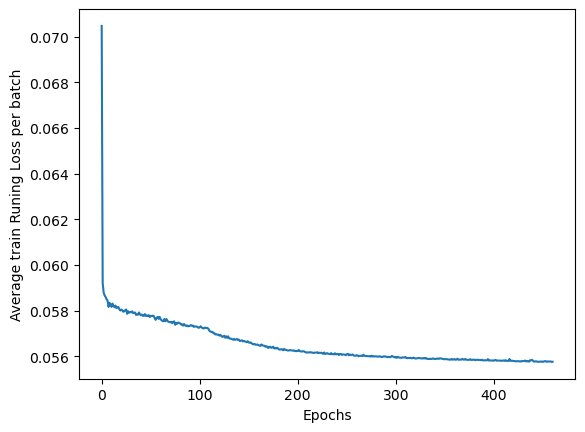

In [23]:
epoch_arr = np.arange(0, len(avg_train_loss_list))
loss_arr = np.array(avg_train_loss_list)
plt.plot(avg_train_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average train Runing Loss per batch")
plt.show()

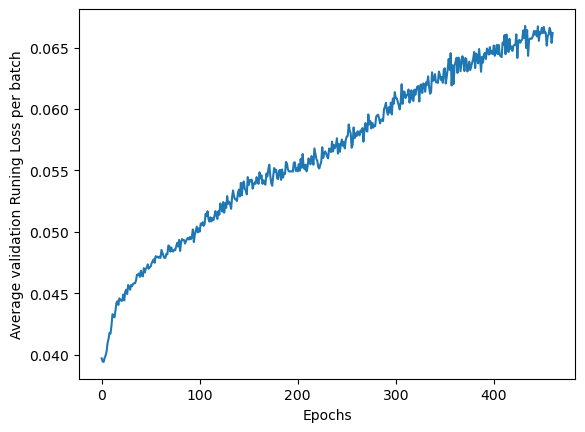

In [24]:
epoch_arr = np.arange(0, len(avg_val_loss_list))
loss_arr = np.array(avg_val_loss_list)
plt.plot(avg_val_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average validation Runing Loss per batch")
plt.show()

In [28]:
torch.save(final_model, 'temp.pt')

In [21]:
normalized_scan_100307_full = np.load(config.norm_data_path + '/normalized_scan_100307_full.npy')

In [22]:
bvals_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvals')

In [23]:
bvals_100307_selected = bvals_all_100307[rand_sub_bval_indice_100206]*1e-3

In [24]:
normalized_scan_100307_sub = normalized_scan_100307_full[:,rand_sub_bval_indice_100206]

In [29]:
big_b_bvals_100307_selected = np.where(bvals_100307_selected != 0.005)[0]

In [30]:
normalized_scan_100307_sub_no_b5 = normalized_scan_100307_sub[:, big_b_bvals_100307_selected]
bvals_100307_selected_no_5 = bvals_100307_selected[big_b_bvals_100307_selected]

In [32]:
n_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvecs')
n_100307_sub = n_all_100307[:,rand_sub_bval_indice_100206]
n_100307_sub_no_b5 = n_100307_sub[:,big_b_bvals_100307_selected].T
print(n_100307_sub_no_b5.shape)

b_values_100307_sub = torch.FloatTensor(bvals_100307_selected_no_5)
gradient_directions_100307_sub = torch.FloatTensor(n_100307_sub_no_b5)

(195, 3)


In [34]:
net = network.BallStickNet(len(b_values_100307_sub))
net.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-BAS-subsets/temp.pt"))
net.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=195, out_features=195, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=195, out_features=195, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=195, out_features=195, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=195, out_features=195, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=195, out_features=195, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=195, out_features=195, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=195, out_features=5, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

In [36]:
X_100307_pred, theta_100307_pred, phi_100307_pred, mu_cart_100307_pred, lambda_par_100307_pred, lambda_iso_100307_pred,  volume_0_100307_pred, volume_1_100307_pred = net(torch.from_numpy(normalized_scan_100307_sub_no_b5.astype(np.float32)),gradient_directions_100307_sub,b_values_100307_sub)

In [38]:
scan_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/data.nii.gz')
mask_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/nodif_brain_mask.nii.gz')
mask_100307_long_pro = process_data.get_mask_pro(scan_100307, mask_100307)

In [40]:
import matplotlib

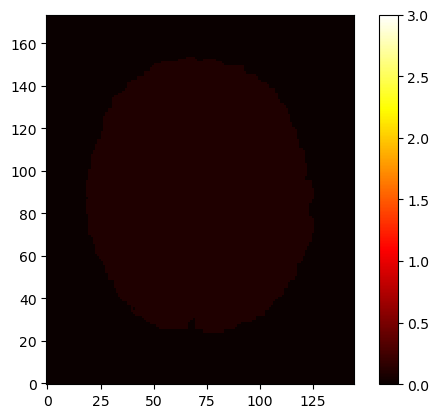

In [41]:
lambda_par_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_par_100307_pred, (145, 174, 145))
im = plt.imshow(lambda_par_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
plt.colorbar(im)

In [3]:
scan_100610 = process_data.get_nifti_data(config.data_folder2 + '/100610/data.nii.gz')
mask_100610 = process_data.get_nifti_data(config.data_folder2 + '/100610/nodif_brain_mask.nii.gz')
scan_dimension = scan_100610.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [4]:
scan_100610_long = np.reshape(scan_100610, (x*y*z, b))

mask_100610_long = np.reshape(mask_100610, (x*y*z, 1))

In [5]:
indices_beginning_0_all = np.where(scan_100610_long[:, 0] == 0)[0]
print(len(indices_beginning_0_all))

2313337


In [6]:
mask_100610_long_pro = np.copy(mask_100610_long)
mask_100610_long_pro[indices_beginning_0_all] = 0

print(len(np.where(mask_100610_long_pro == 0)[0]))

2778196


In [7]:
scan_100610_long_no_background = process_data.remove_background(scan_100610_long, mask_100610_long_pro)

In [8]:
bvals_all_100610 = np.loadtxt(config.data_folder2 + '/100610/bvals') * 1e-3

In [9]:
S0_100610 = process_data.get_S0(scan_100610_long_no_background, bvals_all_100610)

In [11]:
normalized_scan_100610_full = scan_100610_long_no_background / S0_100610

In [14]:
np.save("normalized_scan_100610_full.npy",normalized_scan_100610_full)